In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import NaiveDE
import SpatialDE
from sklearn.preprocessing import scale
from sklearn.mixture import BayesianGaussianMixture
import scipy.cluster.hierarchy as sch
import seaborn as sns
import pickle
import umap
import nimfa
from tqdm import tqdm
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, to_tree
from matplotlib.colors import to_rgb
import warnings
warnings.filterwarnings('ignore')

/home/gapartel/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Import datasets
Import reads and preprocess them.

In [2]:
def T_quality(x):
    return np.clip(1-np.log(1+x)/3.9,0,1)


Q_th = 2
min_count = 500
barcodes_df = []
tagList_df = pd.read_csv("../data/tagList_84-gene.csv", sep = ",", usecols = [0,1], header = None, names = ["Seq","Gene"])
datasets = ['170315_161220_4_1','161230_161220_3_1']
for sample in datasets:
    df = pd.read_csv("../data/results/"+sample+"/barcodes.csv", sep = ",")
    df.seq_quality_min=df.seq_quality_min*df.max_dist.apply(T_quality)
    # Add gene names to dataframe
    d = pd.Series(tagList_df.Gene.values,index=tagList_df.Seq).to_dict()
    df["Gene"] = df['letters'].map(d)
    # Downsample barcode coordinate space by factor 8 for easier visualization
    df["global_X_pos"]=df.global_X_pos/8
    df["global_Y_pos"]=df.global_Y_pos/8
    # Remove reads not in the codebook
    df = df.dropna()
    # Filter reads by quality
    df = df[df.seq_quality_min>Q_th]
    # Filter reads by min count per gene
    df["count"] = 0
    for i,row in tagList_df.iterrows():
        df.loc[df["Gene"] == tagList_df.Gene[i],["count"]] = len(df[df["Gene"] == tagList_df.Gene[i]])
    df = df[df["count"]>min_count]
    
    barcodes_df.append(df)

## Generate expression tables
Generate gene expression table dividing the sample in overlapping patches. The gene expression of each overlapping patch is an entry row int the expression table. Using overlapping patches help to smooth the gene expression between neighbooring patches and consequently to reduce noise.

In [ ]:
# Import and downsample by factor 8 image shape
img_shape = np.round(np.array([[22508, 33566],[22563, 31782]])/8).astype(np.uint)

# Create gene expression table
expression_df = []
sample_df = []
for s_idx, df in enumerate(barcodes_df):
    x_min = 0; x_max= img_shape[s_idx,1];
    y_min = 0; y_max= img_shape[s_idx,0];
    batch_size_px=16
    overlap = 16

    express_table = pd.DataFrame(data={}, columns=df.Gene.unique(), index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))) 
    for i in tqdm(range(x_min,x_max,batch_size_px)):
        for j in range(y_min,y_max,batch_size_px):
            batch_df=df[(df.global_X_pos>=i-(batch_size_px/2)-overlap) & (df.global_X_pos<i+(batch_size_px/2)+overlap) & (df.global_Y_pos>=j-(batch_size_px/2)-overlap) & (df.global_Y_pos<j+(batch_size_px/2)+overlap)]
            if len(batch_df):
                batch_counts = batch_df['Gene'].value_counts()
                express_table.loc[str(i)+'x'+str(j),batch_counts.index]=batch_counts
                
    express_table = express_table.fillna(0)

    # Create sample_info
    sample_info = pd.DataFrame(data={'x':list(x for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)), 'y':list(y for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))}, index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)))
    sample_info['total_counts'] = express_table.sum(axis=1)
    # Dropping empty batches
    express_table = express_table[sample_info.total_counts>10]
    sample_info = sample_info[sample_info.total_counts>10]
    
    expression_df.append(express_table)
    sample_df.append(sample_info)



In [ ]:
# save dataframes
for i,dataset in enumerate(datasets):
    expression_df[i].to_pickle('../data/results/'+dataset+'/express_table.hdf5')
    sample_df[i].to_pickle('../data/results/'+dataset+'/sample_info.hdf5')

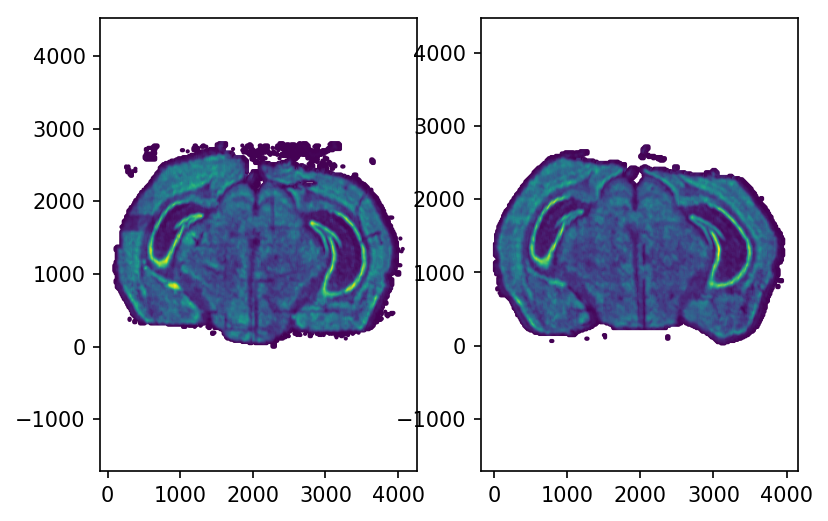

In [3]:
# load dataframes
img_shape = np.round(np.array([[22508, 33566],[22563, 31782]])/8).astype(np.uint)
expression_df = []
sample_df = []
for i,dataset in enumerate(datasets):
    plt.rcParams["figure.dpi"] = 150
    plt.subplot(1,2,i+1)    
    
    x_min = 0; x_max= img_shape[i,1];
    y_min = 0; y_max= img_shape[i,0];
    batch_size_px=16
    overlap = 16
    express_table = pd.read_pickle('../data/results/'+dataset+'/express_table.hdf5')
    # Create sample_info
    sample_info = pd.DataFrame(data={'x':list(x for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)), 'y':list(y for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px))}, index=list((str(x)+"x"+str(y)) for x in range(x_min,x_max,batch_size_px) for y in range(y_min,y_max,batch_size_px)))
    sample_info['total_counts'] = express_table.sum(axis=1)
    # Dropping empty batches
    express_table = express_table[sample_info.total_counts>10]
    sample_info = sample_info[sample_info.total_counts>10]
    
    expression_df.append(express_table)
    expression_df[i] = expression_df[i].rename(('{}_'+str(i)).format)

    sample_df.append(sample_info)
    sample_df[i] = sample_df[i].rename(('{}_'+str(i)).format)
    sample_df[i]['s'] = i
    plt.scatter(sample_df[i]['x'], sample_df[i]['y'], c=sample_df[i]['total_counts'],s=1);
    plt.axis('equal');

## Normalize Gene Expression Tables

In [4]:
expression_df=pd.concat(expression_df,sort=True)
expression_df=expression_df.dropna(axis=1)
#expression_df=expression_df.fillna(0)
sample_df=pd.concat(sample_df,sort=True)
                    
# Linear regression to account for library size and sequencing depth bias of each patch of gene expression
norm_expr = pd.concat([NaiveDE.stabilize(expression_df[sample_df.s==0].T).T,NaiveDE.stabilize(expression_df[sample_df.s==1].T).T])
resid_expr = pd.concat([NaiveDE.regress_out(sample_df[sample_df.s==0], norm_expr[sample_df.s==0].T, 'np.log(total_counts)').T,NaiveDE.regress_out(sample_df[sample_df.s==1], norm_expr[sample_df.s==1].T, 'np.log(total_counts)').T])
idx = resid_expr.var().sort_values(ascending=False).index

## Gene Expression Continuum
Visualize gene expression variantion on sample. Normalized gene expression tables are projected in 3D dimensional embedding and and each entry of the expression table is color coded according to its location 3d space of the embedding. Consequently patches that have similar gene expression signature they will have similar colors.

In [5]:
reducer = umap.UMAP(
        n_neighbors=100,
        min_dist=0.5,
        n_components=3,
        metric='correlation',
        random_state=42,
        init='random')

scaled_expr = np.vstack((scale(resid_expr.loc[sample_df.s==0,idx], 1),scale(resid_expr.loc[sample_df.s==1,idx], 1)))
Y_umap = reducer.fit_transform(scaled_expr)
Y_umap -= np.min(Y_umap, axis=0)
Y_umap /= np.max(Y_umap, axis=0)

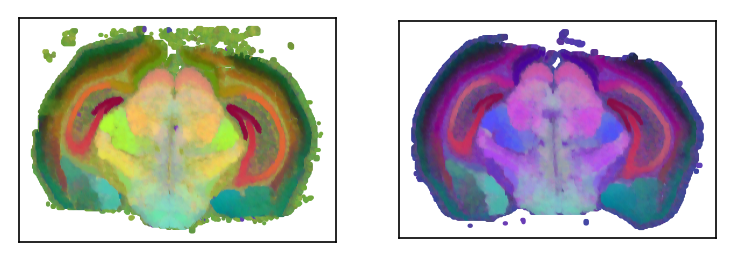

In [6]:
plt.rcParams["figure.dpi"] = 150
plt.figure()
plt.subplot(1,2,1)
plt.scatter(sample_df.loc[sample_df.s==0,:].x, sample_df.loc[sample_df.s==0,:].y, c=Y_umap[sample_df.s==0,:], s=1);
plt.xticks([])
plt.yticks([]);
plt.axis('scaled');

plt.subplot(1,2,2)
plt.scatter(sample_df.loc[sample_df.s==1,:].x, sample_df.loc[sample_df.s==1,:].y, c=Y_umap[sample_df.s==1,:], s=1);
plt.xticks([])
plt.yticks([]);
plt.axis('scaled');

## Gene Expression Clusters
Dimensionality reduction and clustering is applied to each normalized gene expression table, subdividing each brain section in 30 regions.

In [7]:
for i,df in enumerate(datasets):
    # UMAP projection
    idx = resid_expr.loc[sample_df.s==i,:].var().sort_values(ascending=False).index
    reducer = umap.UMAP(
            n_neighbors=100,
            min_dist=0.25,
            n_components=10,
            metric='correlation',
            random_state=42,
            init='random'
        )
    Y_umap = reducer.fit_transform(scale(resid_expr.loc[sample_df.s==i,idx], 1))
    Y=Y_umap

    # Gaussina Mixture Model Clustering
    n_clusters=30
    gmm = BayesianGaussianMixture(n_components=n_clusters, max_iter=100000,random_state=33)
    gmm.fit(Y)
    phi_hat = gmm.predict(Y)
    sample_df.loc[sample_df.s==i,'U1'] = Y[:, 0]
    sample_df.loc[sample_df.s==i,'U2'] = Y[:, 1]
    sample_df.loc[sample_df.s==i,'cluster'] = phi_hat

In [8]:
# Clusters Gene Expression Table
cluster_df = []
for i,df in enumerate(datasets):
    clusters=[]
    for c in np.unique(sample_df.loc[sample_df.s==i,'cluster']):
        clusters.append(expression_df.loc[sample_df[(sample_df.s==i) & (sample_df.cluster==c)].index,:])

    cluster_exp_tab = np.zeros((len(np.unique(sample_df.loc[sample_df.s==i,'cluster'])),len(expression_df.columns.values)))

    for c, cluster in enumerate(np.unique(sample_df.loc[sample_df.s==i,'cluster'])):
        for g, gene in enumerate(expression_df.columns.values):
            # Normalizationtion by cluster area
            cluster_exp_tab[c,g] = clusters[c].loc[:,gene].sum()/len(clusters[c])

    # Normalize by gene (column)
    cluster_exp_tab=cluster_exp_tab/cluster_exp_tab.sum(axis=0)[None,:]
    # Normalize by cluster (row)
    #cluster_exp_tab=cluster_exp_tab/cluster_exp_tab.sum(axis=1)[:,None]
    
    cluster_df.append(pd.DataFrame(cluster_exp_tab,columns=expression_df.columns))

c=np.array(["#9467bd"]*len(cluster_df[0])).tolist()+np.array(["#c5b0d5"]*len(cluster_df[1])).tolist()
cluster_exp_tab=pd.concat(cluster_df,sort=True)
cluster_exp_tab=cluster_exp_tab.fillna(0)

Clustering regions from the two brains are then combined togheter with hierachical clustering based on the gene expression profile of each cluster regions

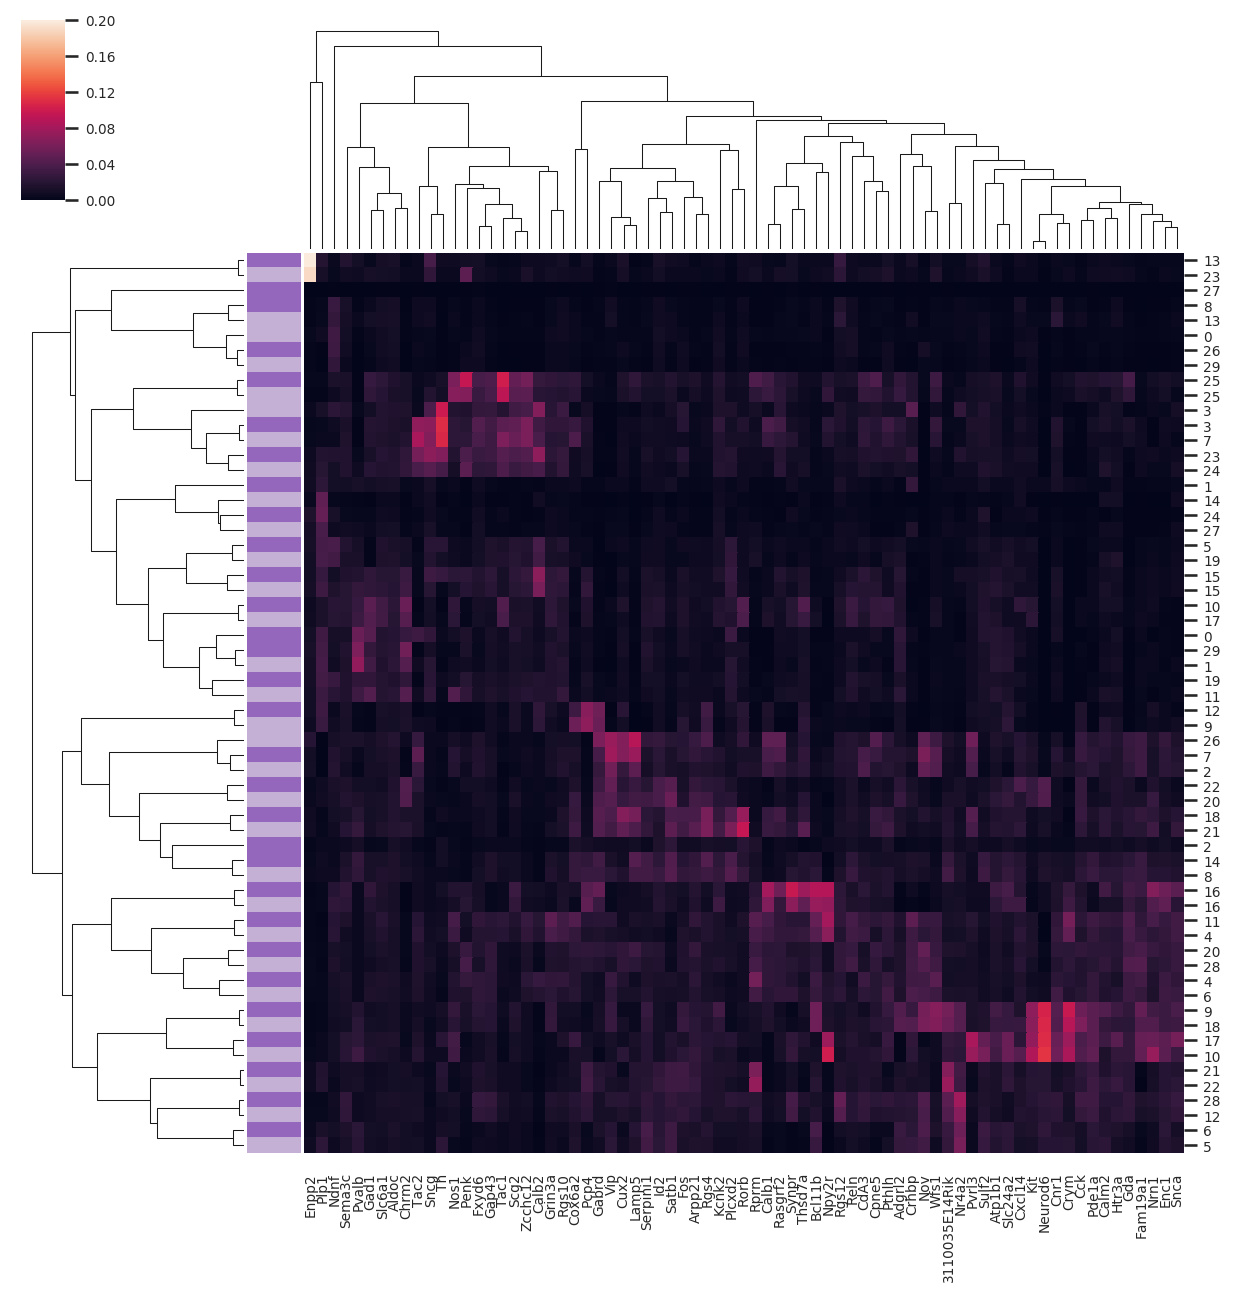

In [9]:
# Plot clustermap
sns.set(font_scale = 0.6)
g=sns.clustermap(np.log10(cluster_exp_tab+1),xticklabels=True, yticklabels=True, metric='correlation',row_colors=c)

Extract top 12 cluster subgroups from the dendogram

In [12]:
# Get linkage matrix
def inorder(tree,G):
    if tree:
        if tree.left:
            G.add_edge(tree.id, tree.left.id)
        if tree.right:
            G.add_edge(tree.id, tree.right.id)
        inorder(tree.left,G)
        inorder(tree.right,G)

def nodes_connected(u, v, G):
    return u in G.neighbors(v)

In [11]:
sample_df.loc[sample_df.s==1,'cluster'] = sample_df.loc[sample_df.s==1,'cluster'] + len(sample_df.loc[sample_df.s==0,'cluster'].unique())
G= nx.DiGraph()

Z= g.dendrogram_row.linkage
T = to_tree( Z , rd=False )
inorder(T,G)

dend = dendrogram(Z,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=20,  # show only the last p merged clusters
           no_plot=True
           )
leafs = [x for x in G.nodes() if G.out_degree(x)==0]
truncated_dend_leafs = dend["leaves"]
color_clusters = []
i=0
for n in truncated_dend_leafs:
    n_list =[]
    for l in leafs:
        if nx.has_path(G,n,l):
            n_list.append(l)
    color_clusters.append(n_list)
    i=i+1    

cluster_exp_tab_idx = cluster_exp_tab.index.tolist()

Plot top 12 clusters on samples

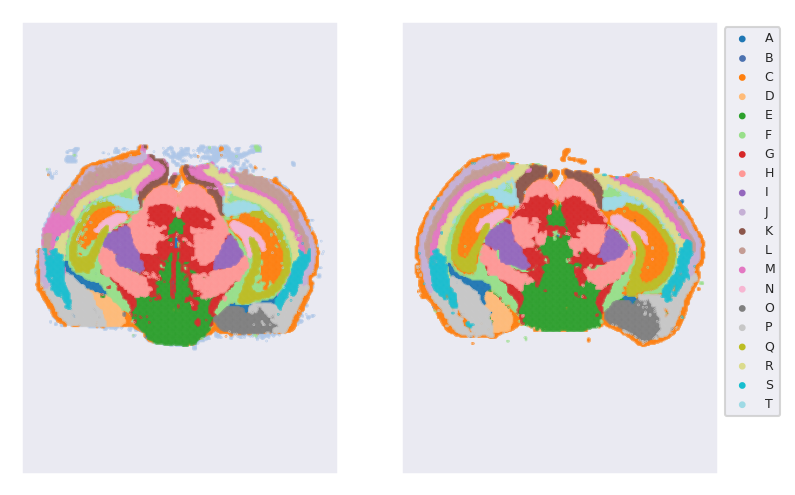

In [13]:
from cycler import cycler
import matplotlib as mpl
from matplotlib.colors import to_rgb
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"])
c_list=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"]


plt.subplot(1,2,1)
c_label = [chr(x) for x in range(65,91)]

i=0
for c in color_clusters:
    g = sample_df.loc[(sample_df.s==0) & (sample_df.cluster.isin(c)),:]
    plt.scatter(g.x, g.y, label=c_label[i], c=np.array([np.array(to_rgb(c_list[i])),]*len(g.x)), s=0.05)
    i = i+1
    
plt.xticks([])
plt.yticks([]);
plt.axis('equal');

plt.subplot(1,2,2)
i=0
for c in color_clusters:
    g = sample_df.loc[(sample_df.s==1) & (sample_df.cluster.isin(c)),:]
    plt.scatter(g.x, g.y, label=c_label[i], c=np.array([np.array(to_rgb(c_list[i])),]*len(g.x)), s=0.05)
    i = i+1
    
plt.xticks([])
plt.yticks([]);
plt.axis('equal');
plt.legend(bbox_to_anchor=(1, 1),loc=2, markerscale=10. ,prop={'size': 6})


Plot subclusters of 12 top cluster regions

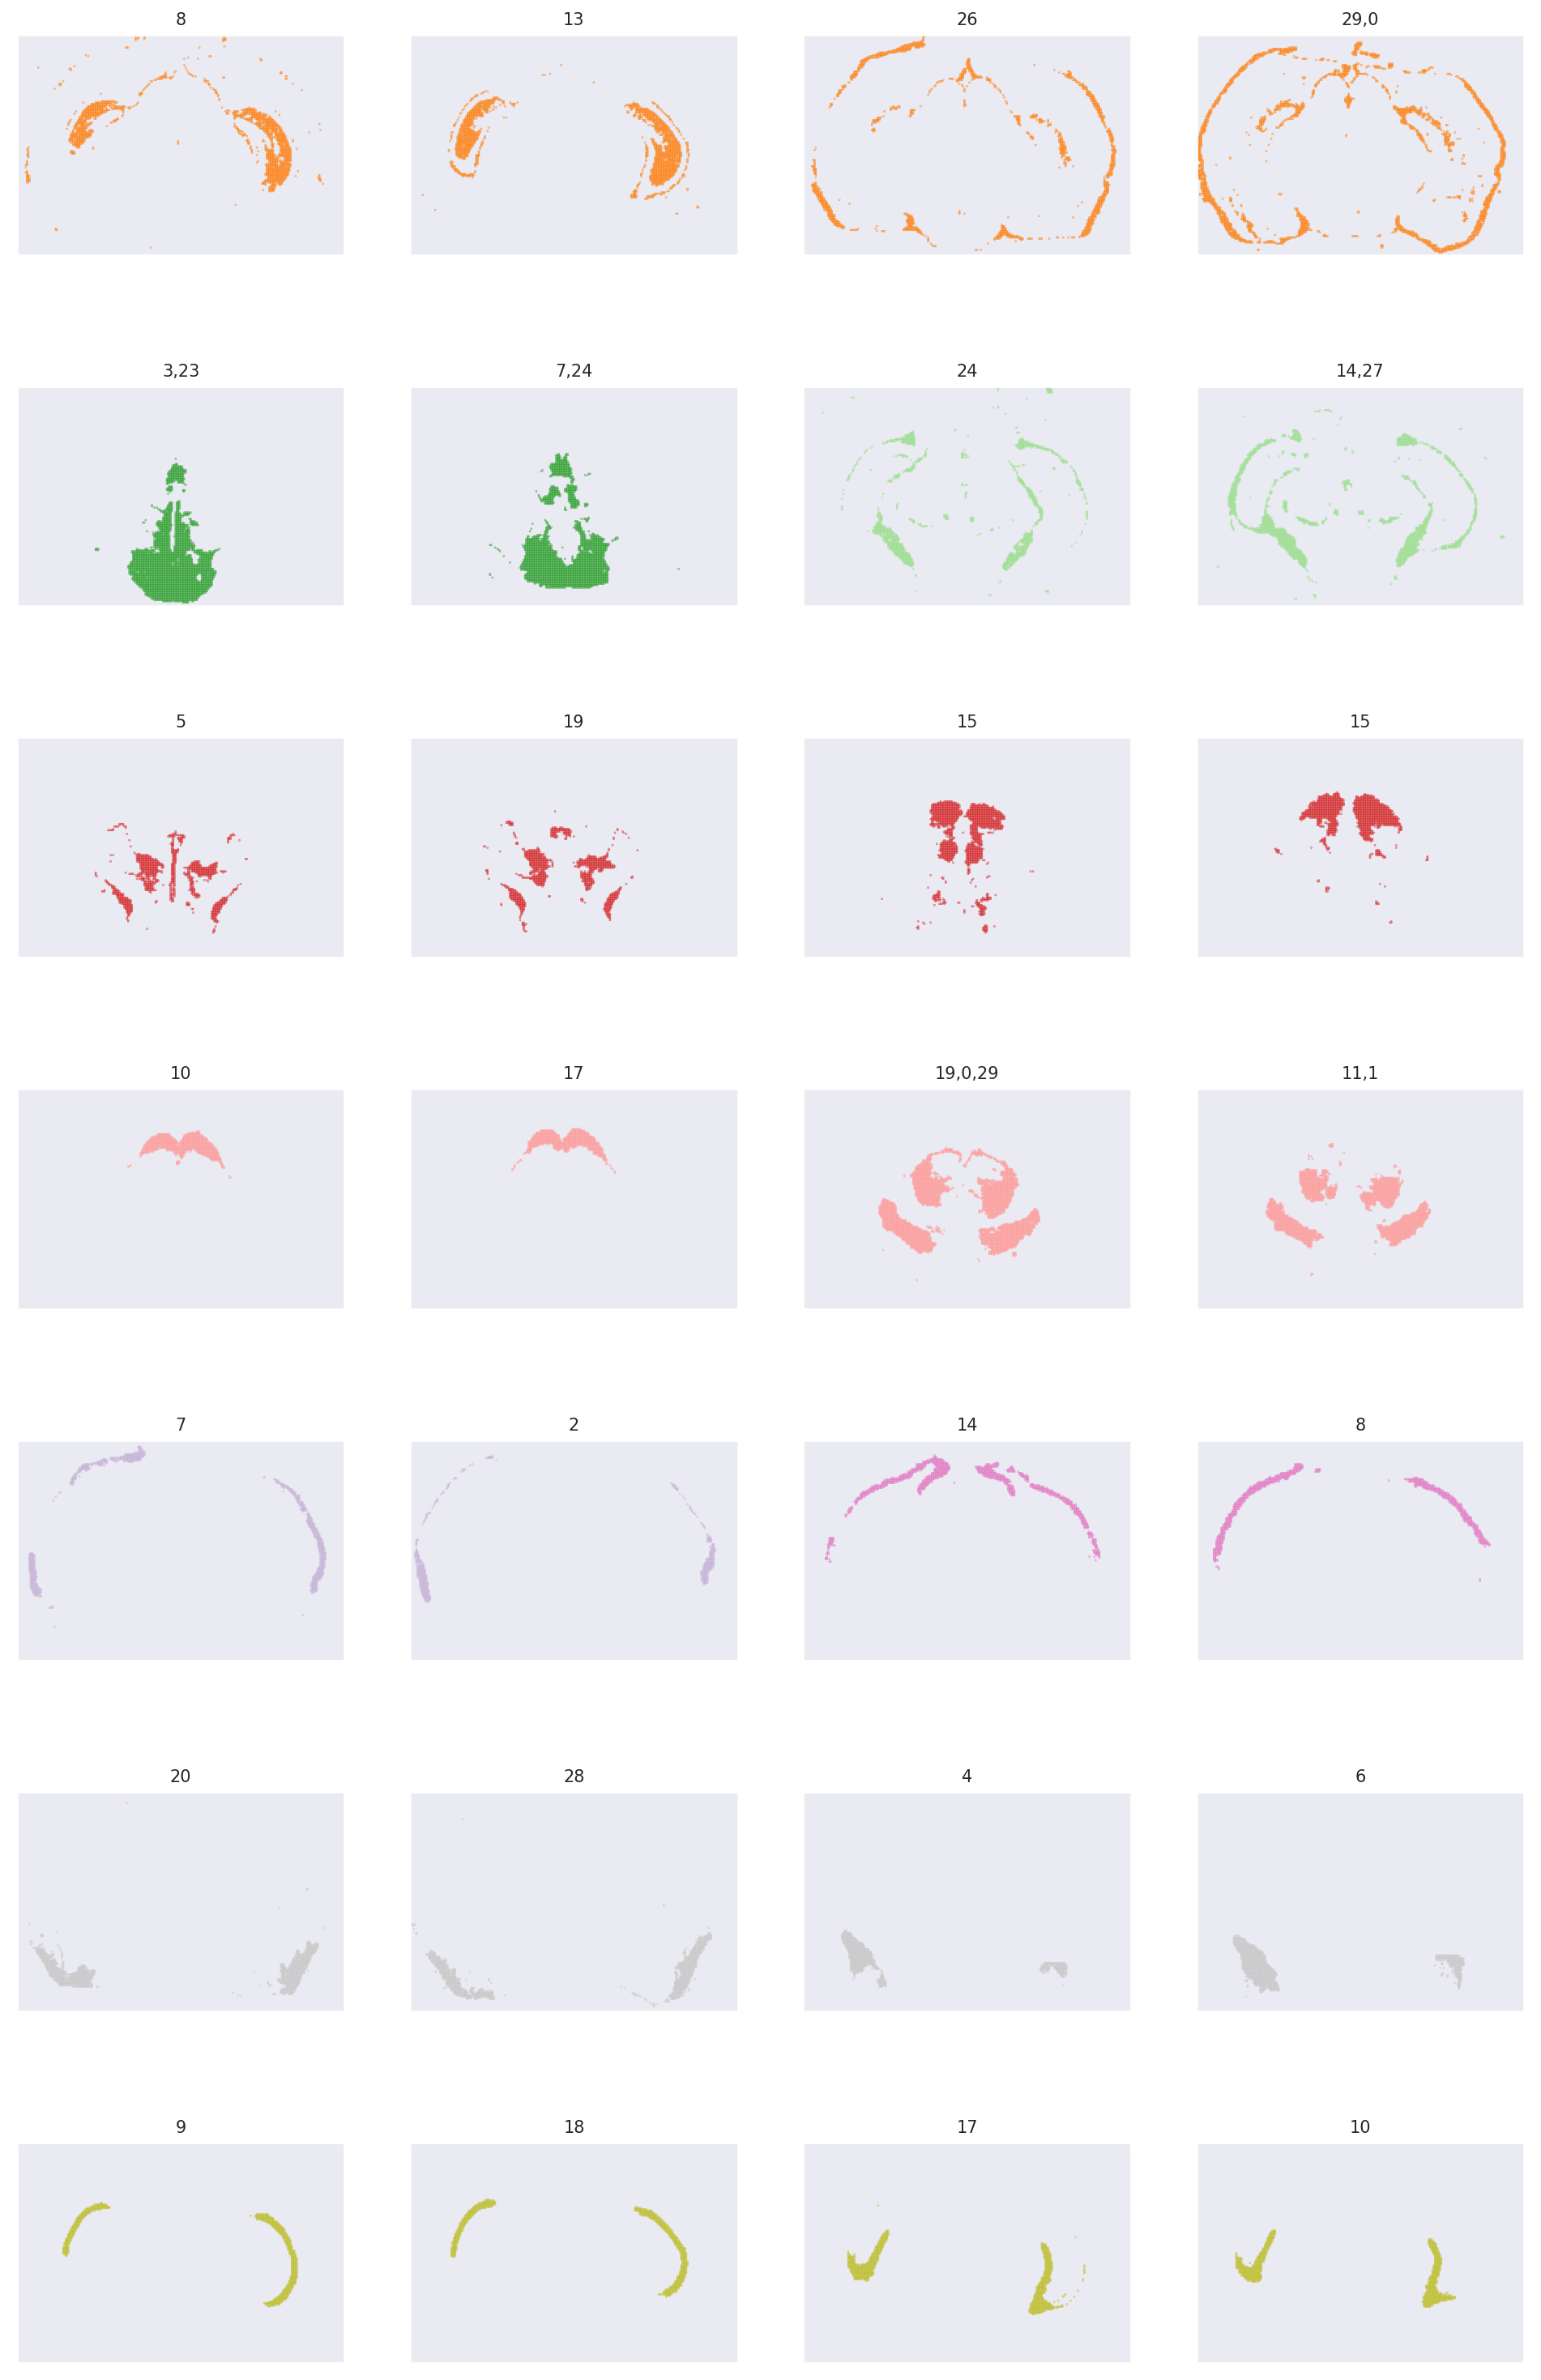

In [14]:
c1 = cluster_df[0]; s1 = sample_df[sample_df.s==0]
c2 = cluster_df[1]; s2 = sample_df[sample_df.s==1]
# Find sub-clusters
color_clusters = []
for n in truncated_dend_leafs:
    leafs = [x for x in G.nodes() if G.out_degree(x)==0 and nx.has_path(G,n,x)]
    succ = list(G.successors(n))
    color_subclusters = []
    for s in succ:
        if not s in leafs:# cluster composed by multiple sub-clusters
            color_subclusters.append([x for x in G.nodes() if G.out_degree(x)==0 and nx.has_path(G,s,x)])
    color_clusters.append(color_subclusters)
    
plt.figure(figsize=(16,30))    
j=1
i=0
for c1 in color_clusters:
    if c1:
        for c2 in c1:
    #        plt.figure()
            plt.subplot(8,4,j)
            j = j+1
            g = s1[s1.cluster.isin(c2)]
            plt.scatter(g.x, g.y, label=f'Cluster {i}', c=np.array([np.array(to_rgb(c_list[i])),]*len(g.x)), s=0.05)
            plt.axis('scaled')
            plt.ylim((0,np.amax(img_shape[:,0])))
            plt.xlim((0,np.amax(img_shape[:,1])))
            plt.title(','.join([str(int(x)) for x in g.cluster.unique().tolist()]),fontsize=10)
            plt.xticks([])
            plt.yticks([]);
        
            
            plt.subplot(8,4,j)
            j = j+1
            g = s2[s2.cluster.isin(c2)]
            plt.scatter(g.x, g.y, label=f'Cluster {i}', c=np.array([np.array(to_rgb(c_list[i])),]*len(g.x)), s=0.05)
            plt.axis('scaled')
            plt.ylim((0,np.amax(img_shape[:,0])))
            plt.xlim((0,np.amax(img_shape[:,1])))
            plt.title(','.join([str(int(x-30)) for x in g.cluster.unique().tolist()]), fontsize=10)
            plt.xticks([])
            plt.yticks([]);
    
    i=i+1


## Marker Expression Clusters
Clustering of brain sections based on a subset of known biomarkers. The two normalized gene expression table are projected in a common lower dimensional space and clustered individually, initializing the parameters for the  clustering of the second brain with the parameters learned from the clustering of the first brain.

In [20]:
markers = ['Calb2', 'Vip', 'Cck', 'Ntng1', 'Cacna2d1', 'Pvalb', 'Sst', 'Pcp4', 'Rprm', 'Rorb', 'Wfs1', 'Plcxd2', 'Crym', '3110035E14Rik', 'Slc24a2', 'Gda', 'Bcl11b', 'Calb1', 'Rgs4', 'Penk', 
'Fam19a1']

# UMAP projection
idx = resid_expr.var().sort_values(ascending=False).index
idx = [x for x in idx if x in markers]
reducer = umap.UMAP(
        n_neighbors=100,
        min_dist=0.25,
        n_components=10,
        metric='correlation',
        random_state=42,
        init='random'
    )
scaled_expr = np.vstack((scale(resid_expr.loc[sample_df.s==0,idx], 1),scale(resid_expr.loc[sample_df.s==1,idx], 1)))
Y_umap = reducer.fit_transform(scaled_expr)
Y=Y_umap

In [27]:
# Gaussina Mixture Model Clustering with warm start
n_clusters=20
gmm = BayesianGaussianMixture(n_components=n_clusters, max_iter=100000, warm_start=True, random_state=35)
for i,df in enumerate(datasets):    
    gmm.fit(Y[sample_df.s==i,:])
    phi_hat = gmm.predict(Y[sample_df.s==i,:])
    sample_df.loc[sample_df.s==i,'U1'] = Y[sample_df.s==i, 0]
    sample_df.loc[sample_df.s==i,'U2'] = Y[sample_df.s==i, 1]
    sample_df.loc[sample_df.s==i,'cluster'] = phi_hat

Cluster 0.0
Cluster 1.0
Cluster 2.0
Cluster 3.0
Cluster 4.0
Cluster 5.0
Cluster 6.0
Cluster 7.0
Cluster 8.0
Cluster 9.0
Cluster 10.0
Cluster 11.0
Cluster 12.0
Cluster 13.0
Cluster 14.0
Cluster 15.0
Cluster 16.0
Cluster 17.0
Cluster 18.0
Cluster 19.0
Cluster 0.0
Cluster 1.0
Cluster 2.0
Cluster 3.0
Cluster 4.0
Cluster 5.0
Cluster 6.0
Cluster 7.0
Cluster 8.0
Cluster 9.0
Cluster 10.0
Cluster 11.0
Cluster 12.0
Cluster 13.0
Cluster 14.0
Cluster 15.0
Cluster 16.0
Cluster 17.0
Cluster 18.0
Cluster 19.0


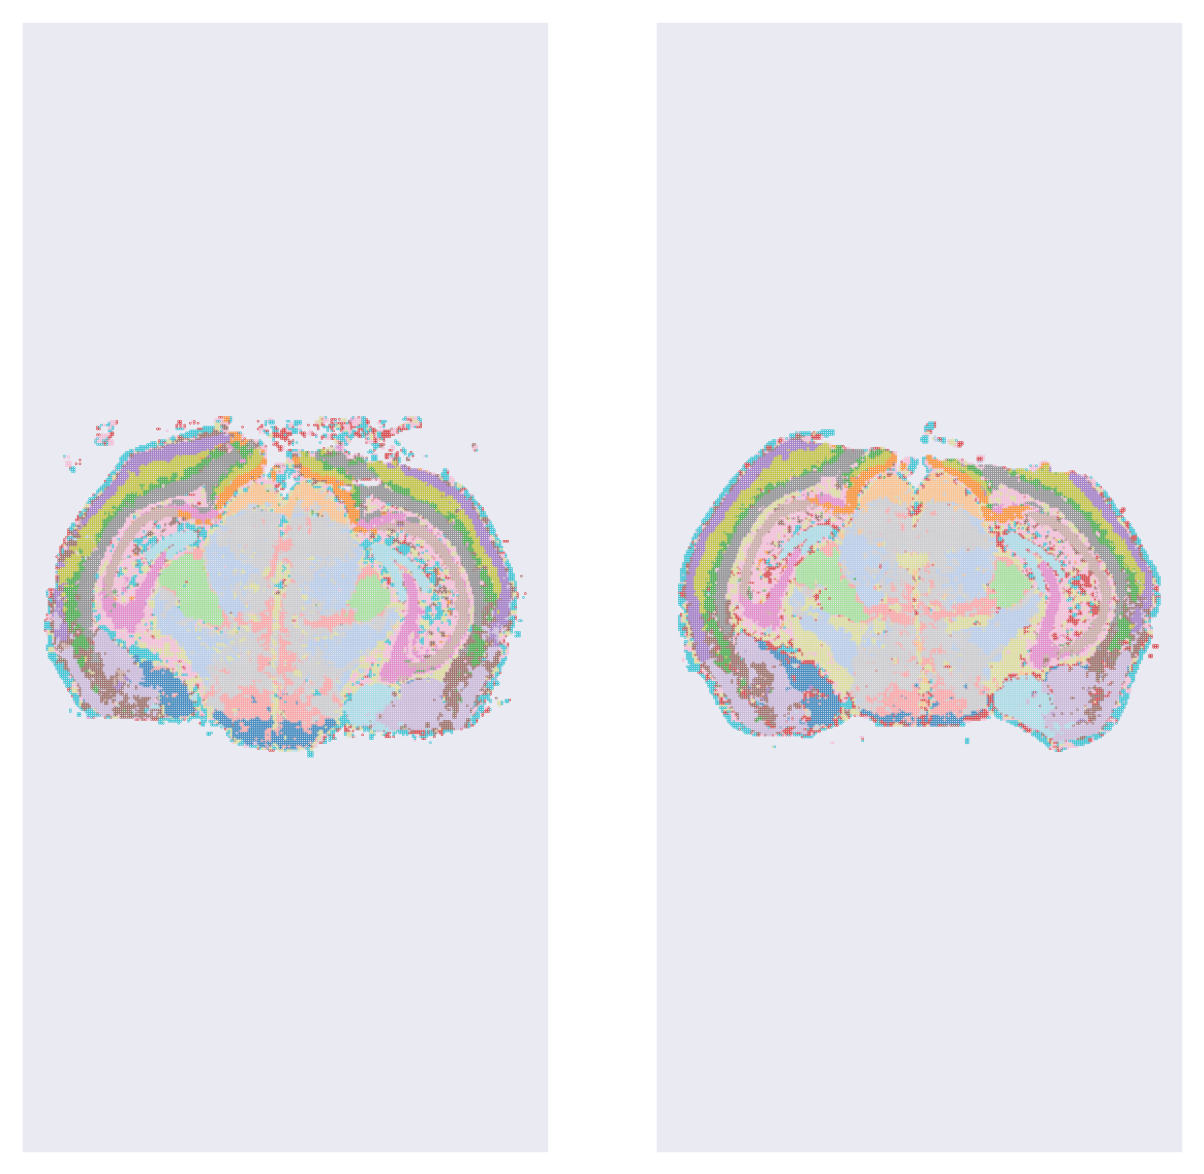

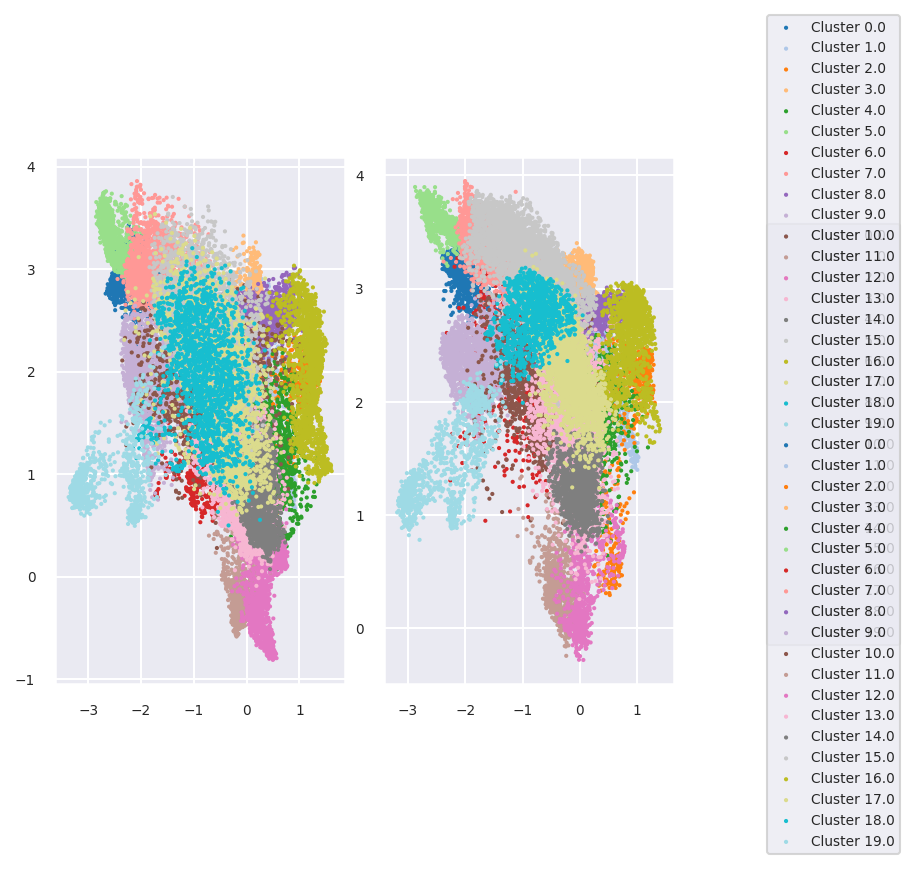

In [28]:
from cycler import cycler
import matplotlib as mpl
from matplotlib.colors import to_rgb
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"])
c_list=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"]



plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
for i, g in sample_df.loc[sample_df.s==0,:].groupby('cluster'):
    plt.scatter(g.x, g.y, label=f'Cluster {i}', c=np.array([np.array(to_rgb(c_list[int(i)])),]*len(g.x)), s=0.05)
plt.xticks([])
plt.yticks([]);
plt.axis('equal');

plt.subplot(1,2,2)
for i, g in sample_df.loc[sample_df.s==1,:].groupby('cluster'):
    plt.scatter(g.x, g.y, label=f'Cluster {i}', c=np.array([np.array(to_rgb(c_list[int(i)])),]*len(g.x)), s=0.05)
plt.xticks([])
plt.yticks([]);
plt.axis('equal');


fig=plt.figure()
plt.subplot(1,2,1)
for i, g in sample_df.loc[sample_df.s==0,:].groupby('cluster'):
    print(f'Cluster {i}')
    plt.scatter(g.U1, g.U2,label=f'Cluster {i}', c=np.array([np.array(to_rgb(c_list[int(i)])),]*len(g.x)), s=1)
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.75)

plt.subplot(1,2,2)
for i, g in sample_df.loc[sample_df.s==1,:].groupby('cluster'):
    print(f'Cluster {i}')
    plt.scatter(g.U1, g.U2,label=f'Cluster {i}', c=np.array([np.array(to_rgb(c_list[int(i)])),]*len(g.x)), s=1)
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.75)



In [29]:
# Clusters Gene Expression Table
cluster_df = []
for i,df in enumerate(datasets):
    clusters=[]
    for c in np.unique(sample_df.loc[sample_df.s==i,'cluster']):
        clusters.append(expression_df.loc[sample_df[(sample_df.s==i) & (sample_df.cluster==c)].index,idx])

    cluster_exp_tab = np.zeros((len(np.unique(sample_df.loc[sample_df.s==i,'cluster'])),len(idx)))

    for c, cluster in enumerate(np.unique(sample_df.loc[sample_df.s==i,'cluster'])):
        for g, gene in enumerate(idx):
            # Normalizationtion by cluster area
            cluster_exp_tab[c,g] = clusters[c].loc[:,gene].sum()/len(clusters[c])

    # Normalize by gene (column)
    cluster_exp_tab=cluster_exp_tab/cluster_exp_tab.sum(axis=0)[None,:]
    # Normalize by cluster (row)
    #cluster_exp_tab=cluster_exp_tab/cluster_exp_tab.sum(axis=1)[:,None]
    
    cluster_df.append(pd.DataFrame(cluster_exp_tab,columns=idx))

c=np.array(["#9467bd"]*len(cluster_df[0])).tolist()+np.array(["#c5b0d5"]*len(cluster_df[1])).tolist()
cluster_exp_tab=pd.concat(cluster_df,sort=True)
cluster_exp_tab=cluster_exp_tab.fillna(0)

Clustering regions from the two brains are then combined togheter with hierachical clustering based on the gene expression profile of each cluster regions

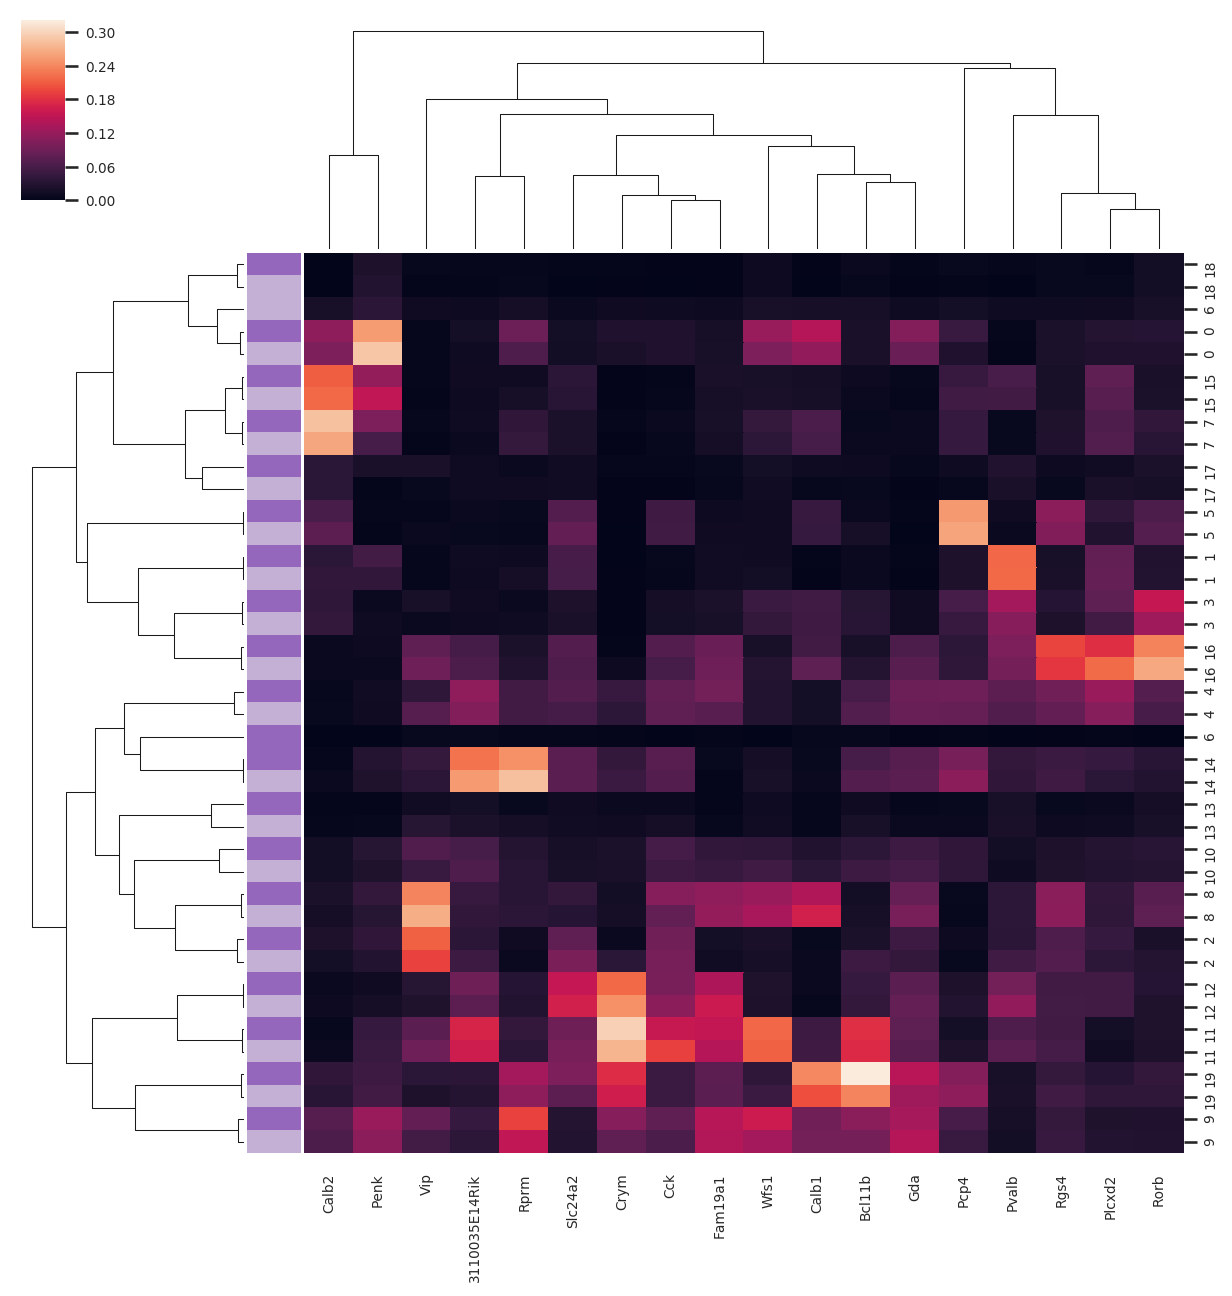

In [30]:
# Plot clustermap
sns.set(font_scale = 0.6)
g=sns.clustermap(cluster_exp_tab,xticklabels=True, yticklabels=True, metric='correlation',row_colors=c)

In [31]:
sample_df.loc[sample_df.s==1,'cluster'] = sample_df.loc[sample_df.s==1,'cluster'] + len(sample_df.loc[sample_df.s==0,'cluster'].unique())
G= nx.DiGraph()

Z= g.dendrogram_row.linkage
T = to_tree( Z , rd=False )
inorder(T,G)

dend = dendrogram(Z,
           truncate_mode=None,  # show only the last p merged clusters
           p=2,  # show only the last p merged clusters
           no_plot=True
           )
leafs = [x for x in G.nodes() if G.out_degree(x)==0]
l1_nodes = [list(G.predecessors(x))[0] for x in leafs]

l1_nodes =np.array(l1_nodes)
leafs = np.array(leafs)
color_clusters = []
i=0
for n in np.unique(l1_nodes):
    color_clusters.append(leafs[np.where(l1_nodes==n)])
    i=i+1

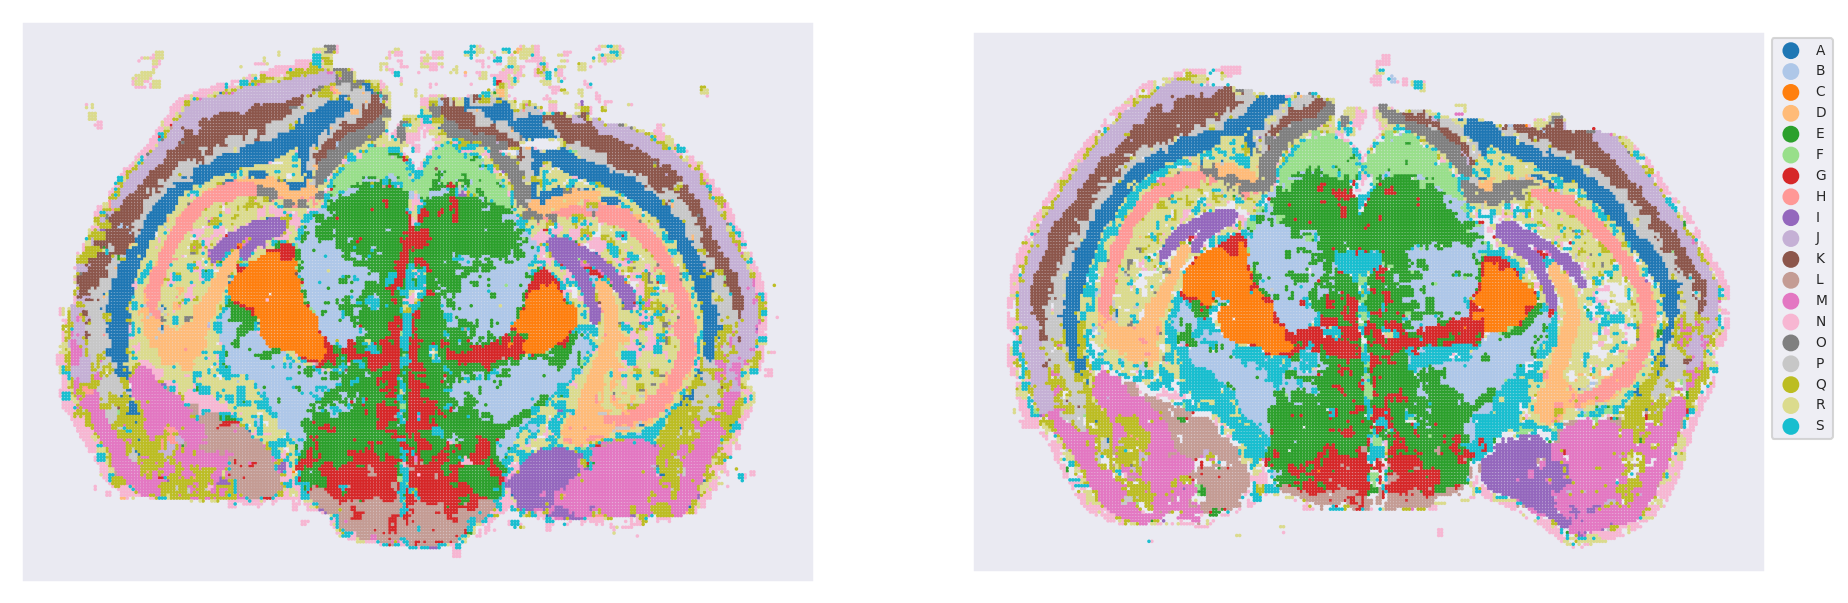

In [32]:
from cycler import cycler
import matplotlib as mpl
from matplotlib.colors import to_rgb
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"])
c_list=["#1f77b4","#aec7e8","#ff7f0e","#ffbb78","#2ca02c","#98df8a","#d62728","#ff9896","#9467bd","#c5b0d5","#8c564b","#c49c94","#e377c2","#f7b6d2","#7f7f7f","#c7c7c7","#bcbd22","#dbdb8d","#17becf","#9edae5"]

plt.figure(figsize=(15,20))
plt.subplot(1,2,1)
c_label = [chr(x) for x in range(65,91)]

i=0
for c in color_clusters:
    if len(c)>1:
        g = sample_df.loc[(sample_df.s==0) & (sample_df.cluster.isin(c)),:]
        plt.scatter(g.x, g.y, label=c_label[i], c=np.array([np.array(to_rgb(c_list[i])),]*len(g.x)), s=0.5)
        i = i+1
    
plt.xticks([])
plt.yticks([]);
plt.axis('scaled');

plt.subplot(1,2,2)
i=0
for c in color_clusters:
    if len(c)>1:
        g = sample_df.loc[(sample_df.s==1) & (sample_df.cluster.isin(c)),:]
        plt.scatter(g.x, g.y, label=c_label[i], c=np.array([np.array(to_rgb(c_list[i])),]*len(g.x)), s=0.5)
        i = i+1
    
plt.xticks([])
plt.yticks([]);
plt.axis('scaled');
plt.legend(bbox_to_anchor=(1, 1),loc=2, markerscale=10)


## Evaluate clusters with high correlation

In [33]:
# Print cluster correlations
cluster_corr = []
i=0
for j,c in enumerate(color_clusters):
    print(i,j)
    if len(c)>1:
        print("Clusters "+ str(c) +" correlation: "+ str(np.corrcoef(cluster_exp_tab.iloc[c,:])[0,1]))
        cluster_corr.append(np.corrcoef(cluster_exp_tab.iloc[c,:])[0,1])
        i = i+1
    else:
        cluster_corr.append(0)

0 0
Clusters [14 34] correlation: 0.9968627640727109
1 1
Clusters [ 1 21] correlation: 0.9962362566682146
2 2
Clusters [ 5 25] correlation: 0.994204351262436
3 3
Clusters [12 32] correlation: 0.9938003538343385
4 4
Clusters [15 35] correlation: 0.9907708951418309
5 5
Clusters [ 3 23] correlation: 0.9900977658802352
6 6
Clusters [ 7 27] correlation: 0.9891582235535071
7 7
Clusters [11 31] correlation: 0.9888857367941788
8 8
Clusters [19 39] correlation: 0.9865727777999654
9 9
Clusters [ 8 28] correlation: 0.9863504056452366
10 10
Clusters [16 36] correlation: 0.9860431464177943
11 11
Clusters [ 0 20] correlation: 0.9810257861206654
12 12
Clusters [ 9 29] correlation: 0.966509047404094
13 13
Clusters [18 38] correlation: 0.9643425623538627
14 14
Clusters [ 2 22] correlation: 0.9603142347304644
15 15
Clusters [ 4 24] correlation: 0.9463301654129874
16 16
Clusters [10 30] correlation: 0.8605047279265903
17 17
17 18
Clusters [13 33] correlation: 0.8159578371377747
18 19
Clusters [17 37] cor

Filter clusters with correlation lower than 0.9

In [34]:
cluster_corr = np.array(cluster_corr)
d = dict(zip(np.arange(len(cluster_corr)),[x for x in np.where(cluster_corr>0.9)[0]]))
color_clusters = [color_clusters[x] for x in np.where(cluster_corr>0.9)[0]]

In [35]:
# Save gene expression matrix for seurat DE analysis
for i,c in enumerate(color_clusters):
    sample_df.loc[sample_df.cluster.isin(c),'top_cluster'] = i
sample_df = sample_df.dropna()
sample_df.to_csv('../data/results/sample_info.csv')
pos_res_exp = resid_expr - resid_expr.min().min()
idx = [x for x in resid_expr.columns if not x in markers]
pos_res_exp = pos_res_exp.loc[sample_df.index,idx]
pos_res_exp.T.to_csv('../data/results/residuals.csv')

expression_df.loc[sample_df.index,idx].T.to_csv('../data/results/expression.csv')
scaled_expr = pd.DataFrame(scale(resid_expr.loc[:,idx], 1), index=resid_expr.index, columns=idx)
scaled_expr.loc[sample_df.index,idx].T.to_csv('../data/results/scaled.csv')
sample_df.to_csv('../data/results/sample_morpho.csv')

## Find differentially expressed features between clusters (cluster biomarkers)
Run differential expression analysis with Seurat 3 before continue. Execute in terminal:

`Rscript DE_analysis.R`

In [25]:
def get_label(x):
    c_label = [chr(x) for x in range(65,91)]
    return c_label[x]

markers = pd.read_csv('../data/results/markers.csv')
markers = markers[markers.avg_diff>0]
markers.cluster = markers.cluster.map(d).apply(get_label)
markers

p_val   avg_diff  pct.1  pct.2      p_val_adj     Gene cluster
0    0.000000e+00  17.282679  1.000  0.994   0.000000e+00      Id2       A
1    0.000000e+00  12.529867  0.998  0.877   0.000000e+00    Pde1a       A
2    0.000000e+00   7.468613  0.989  0.864   0.000000e+00    Satb1       A
3    0.000000e+00   6.931222  0.994  0.593   0.000000e+00  Neurod6       A
4   8.473697e-138   7.025252  0.999  0.927  4.660533e-136     Enc1       A
5    0.000000e+00  51.107560  0.997  0.896   0.000000e+00     Plp1       B
6    0.000000e+00  15.541664  0.926  0.906   0.000000e+00     Gad1       B
7    0.000000e+00   2.437011  0.994  0.960   0.000000e+00   Atp1b1       B
8    0.000000e+00   2.431086  0.998  0.934   0.000000e+00    Enpp2       B
9   5.661538e-184   9.237628  0.999  0.991  3.113846e-182    Aldoc       B
10   0.000000e+00  36.242490  0.998  0.902   0.000000e+00     Plp1       C
11   0.000000e+00   1.416846  0.774  0.262   0.000000e+00    Gabrd       C
12   0.000000e+00   1.372387  0.745  0.386   0.000000e+00   Cox6a2       C
13  1.282559e-302   0.226662  0.435  0.301  7.054072e-301   Thsd7a       C
14  1.781745e-207   0.174245  0.655  0.526  9.799597e-206     Cux2       C
15   0.000000e+00  82.448500  0.990  0.603   0.000000e+00  Neurod6       D
16   0.000000e+00  32.366014  0.986  0.929   0.000000e+00     Enc1       D
17   0.000000e+00  19.323727  0.986  0.881   0.000000e+00    Pde1a       D
18   2.306332e-79   8.633367  0.802  0.574   1.268483e-77     Snca       D
19   9.527286e-30  14.968936  0.992  0.962   5.240007e-28   Atp1b1       D
20   0.000000e+00  32.919710  0.998  0.888   0.000000e+00     Plp1       E
21   0.000000e+00  13.361126  1.000  0.975   0.000000e+00    Gap43       E
22   0.000000e+00   6.826654  0.997  0.911   0.000000e+00     Scg2       E
23  4.297525e-196   4.202190  0.920  0.906  2.363639e-194     Gad1       E
24   6.972253e-45   6.117714  1.000  0.991   3.834739e-43    Aldoc       E
25   0.000000e+00  25.509468  0.971  0.907   0.000000e+00     Gad1       F
26   0.000000e+00   8.327752  1.000  0.960   0.000000e+00   Slc6a1       F
27   0.000000e+00   5.584541  0.914  0.607   0.000000e+00     Tac1       F
28  1.545007e-256   4.797060  0.975  0.886  8.497536e-255     Reln       F
29   3.481972e-43  10.777285  1.000  0.992   1.915084e-41    Aldoc       F
..            ...        ...    ...    ...            ...      ...     ...
47   0.000000e+00   5.106762  0.996  0.938   0.000000e+00    Enpp2       J
48  7.450274e-288  15.268865  0.999  0.994  4.097650e-286      Id2       J
49  1.826420e-121   6.206996  0.993  0.900  1.004531e-119   Arpp21       J
50   0.000000e+00  14.314413  1.000  0.864   0.000000e+00    Satb1       K
51   0.000000e+00  11.688566  0.992  0.899   0.000000e+00   Arpp21       K
52   0.000000e+00   9.915442  0.980  0.643   0.000000e+00    Lamp5       K
53   5.531666e-72   3.599891  0.999  0.992   3.042417e-70    Aldoc       K
54   8.740633e-50   3.001721  0.999  0.994   4.807348e-48      Id2       K
55   0.000000e+00  32.399282  0.999  0.978   0.000000e+00    Gap43       L
56   0.000000e+00  19.973268  0.993  0.923   0.000000e+00     Scg2       L
57   0.000000e+00  13.150628  0.881  0.605   0.000000e+00     Tac1       L
58   0.000000e+00   8.888107  0.990  0.766   0.000000e+00  Zcchc12       L
59   0.000000e+00   4.763469  0.988  0.853   0.000000e+00    Fxyd6       L
60   0.000000e+00  20.379339  0.999  0.925   0.000000e+00     Enc1       M
61   0.000000e+00   8.776514  0.996  0.875   0.000000e+00    Pde1a       M
62  1.788527e-103  14.403521  0.999  0.977  9.836898e-102    Gap43       M
63   4.252251e-25   3.613694  0.721  0.667   2.338738e-23    Calm2       M
64   7.101455e-16   4.050685  0.991  0.897   3.905800e-14   Arpp21       M
67   4.098626e-95   0.376308  0.478  0.378   2.254244e-93     Ndnf       N
68   1.934653e-28  24.308460  0.752  0.953   1.064059e-26    Enpp2       N
70   0.000000e+00  39.067023  0.998  0.994   0.000000e+00      Id2       O
71   0.000000e+00  30.469843  0.977  

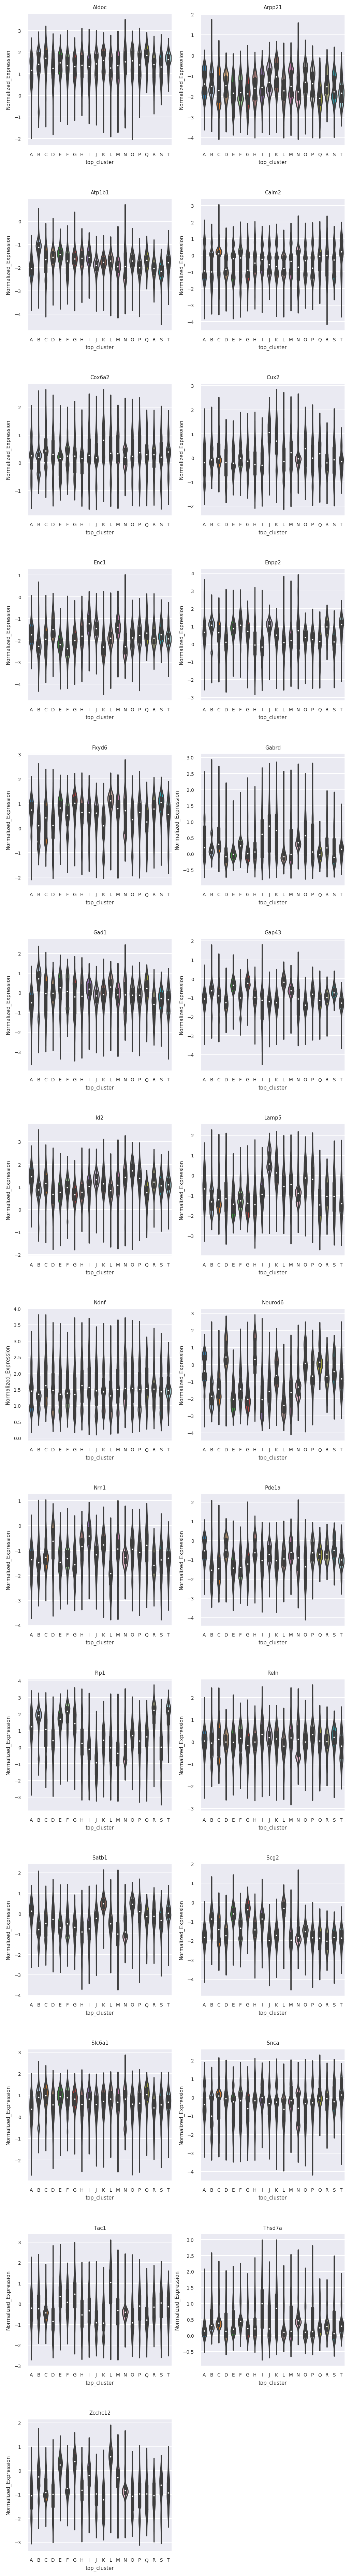

In [26]:
# DE analysis of genes not in marker list (not used for clustering)
scaled_expr = scaled_expr.loc[sample_df.index,idx]
markers = markers.Gene.unique()
idx=[x for x in expression_df.columns if x in markers]
plt.figure(figsize=(8,128))
for i,gene in enumerate(idx):
    gene_exp = pd.DataFrame({'Normalized_Expression':scaled_expr.loc[:,gene], 's':sample_df.s, 'top_cluster':sample_df.top_cluster.astype(np.uint).apply(get_label)})
    plt.subplot(len(idx),2,i+1)
    ax = sns.violinplot(x="top_cluster", y="Normalized_Expression", data=gene_exp, palette= c_list, order=c_label[0:len(gene_exp.top_cluster.unique())])
    #ax.legend_.remove()
    plt.title(gene)
    plt.subplots_adjust(hspace=0.4)

## Find Differentially Expressed Genes between samples

In [27]:
def get_label(x):
    c_label = [chr(x) for x in range(65,91)]
    return c_label[x]

markers = pd.read_csv('../data/results/markers_samples.csv')
markers = markers.set_index('Gene')
markers.cluster = markers.cluster.map(d).apply(get_label)
markers

p_val   avg_diff  pct.1  pct.2      p_val_adj cluster
Gene                                                                   
Calm2      0.000000e+00  14.831828  0.998  0.487   0.000000e+00       A
Snca       0.000000e+00   6.801763  0.979  0.539   0.000000e+00       A
Arpp21     0.000000e+00   1.861205  0.993  0.995   0.000000e+00       A
Neurod6    0.000000e+00  -3.824075  0.992  0.997   0.000000e+00       A
Aldoc      0.000000e+00  -4.479425  0.997  0.997   0.000000e+00       A
Enc1       0.000000e+00  -7.970528  0.999  0.999   0.000000e+00       A
Pde1a      0.000000e+00  -8.108216  0.998  0.999   0.000000e+00       A
Rasgrf2   2.666129e-289   0.630165  0.553  0.275  1.466371e-287       A
Slc6a1    5.501470e-263  -0.845167  0.898  0.949  3.025808e-261       A
Id2       3.148002e-185  16.499680  1.000  0.999  1.731401e-183       A
Cxcl14    4.625958e-173  -0.964958  0.880  0.937  2.544277e-171       A
Gap43     1.204296e-152  -5.908463  0.997  0.999  6.623628e-151       A
Synpr     9.427673e-144  -0.180648  0.233  0.291  5.185220e-142       A
Ndnf      1.444074e-134   0.198275  0.294  0.186  7.942408e-133       A
Rgs10     5.211674e-134   0.034571  0.300  0.257  2.866421e-132       A
Htr3a     9.967000e-126   0.633138  0.889  0.860  5.481850e-124       A
Lamp5     2.679812e-119  -2.943765  0.848  0.906  1.473897e-117       A
Cux2       9.822337e-80   0.188532  0.429  0.442   5.402285e-78       A
Pvrl3      1.687210e-74  -0.097852  0.236  0.332   9.279654e-73       A
Serpini1   6.570757e-74   0.043983  0.778  0.800   3.613916e-72       A
Satb1      2.123304e-73  -3.037523  0.984  0.994   1.167817e-71       A
Crhbp      2.314474e-67   0.321919  0.358  0.153   1.272961e-65       A
Nov        5.262211e-66  -0.511437  0.606  0.783   2.894216e-64       A
Chrm2      1.086740e-64  -0.186066  0.486  0.554   5.977070e-63       A
Atp1b1     7.425024e-61  -0.774165  0.991  0.994   4.083763e-59       A
Cox6a2     1.423773e-60   0.507760  0.534  0.279   7.830753e-59       A
Tac2       2.549187e-57  -0.168286  0.200  0.331   1.402053e-55       A
Sncg       1.999270e-55  -0.226100  0.134  0.299   1.099599e-53       A
Nr4a2      6.209266e-53  -0.055443  0.659  0.671   3.415096e-51       A
Nos1       1.222594e-50  -0.099013  0.176  0.252   6.724266e-49       A
...                 ...        ...    ...    ...            ...     ...
Nos1       2.015479e-53  -0.008626  0.266  0.279   1.108514e-51       P
Crhbp      4.336669e-50   0.411183  0.360  0.151   2.385168e-48       P
Cpne5      1.244898e-45   1.132165  0.816  0.526   6.846937e-44       P
Pvrl3      5.980710e-44  -0.150037  0.372  0.459   3.289390e-42       P
Fxyd6      1.018533e-38  -2.641642  0.860  0.977   5.601931e-37       P
Tac2       1.269390e-36  -0.200511  0.182  0.360   6.981643e-35       P
Rgs12      2.630633e-34   0.245829  0.662  0.625   1.446848e-32       P
Chrm2      1.599804e-31  -0.292889  0.493  0.597   8.798923e-30       P
Atp1b1     9.511367e-31   0.519938  0.996  0.999   5.231252e-29       P
Enpp2      1.810433e-30  -0.811229  0.934  0.961   9.957381e-29       P
Gabrd      1.115561e-28  -0.030157  0.469  0.468   6.135584e-27       P
Grin3a     1.087160e-25  -0.516532  0.734  0.819   5.979378e-24       P
CdA3       1.085088e-24  -0.072814  0.760  0.739   5.967986e-23       P
Scg2       5.194638e-22  -0.036381  0.972  0.949   2.857051e-20       P
Cox6a2     1.114746e-18   0.765344  0.717  0.468   6.131105e-17       P
Adgrl2     2.689021e-18  -0.306603  0.595  0.697   1.478961e-16       P
Nr4a2      5.674268e-12  -0.235515  0.455  0.520   3.120847e-10       P
Kit        2.177251e-09   0.389831  0.604  0.523   1.197488e-07       P
Cux2       5.388000e-09   0.580080  0.622  0.490   2.963400e-07       P
Reln       3.500524e-07  -2.010446  0.989  0.988   1.925288e-05       P
Tac1       6.456750e-06   0.821937  0.801  0.735   3.551212e-04       P
Fos        9.638340e-06   0.049793  0.474  0.455   5.301087e-04       P
Gad1       1.052598e-05   6.826239  0.995  0.981   5.78928

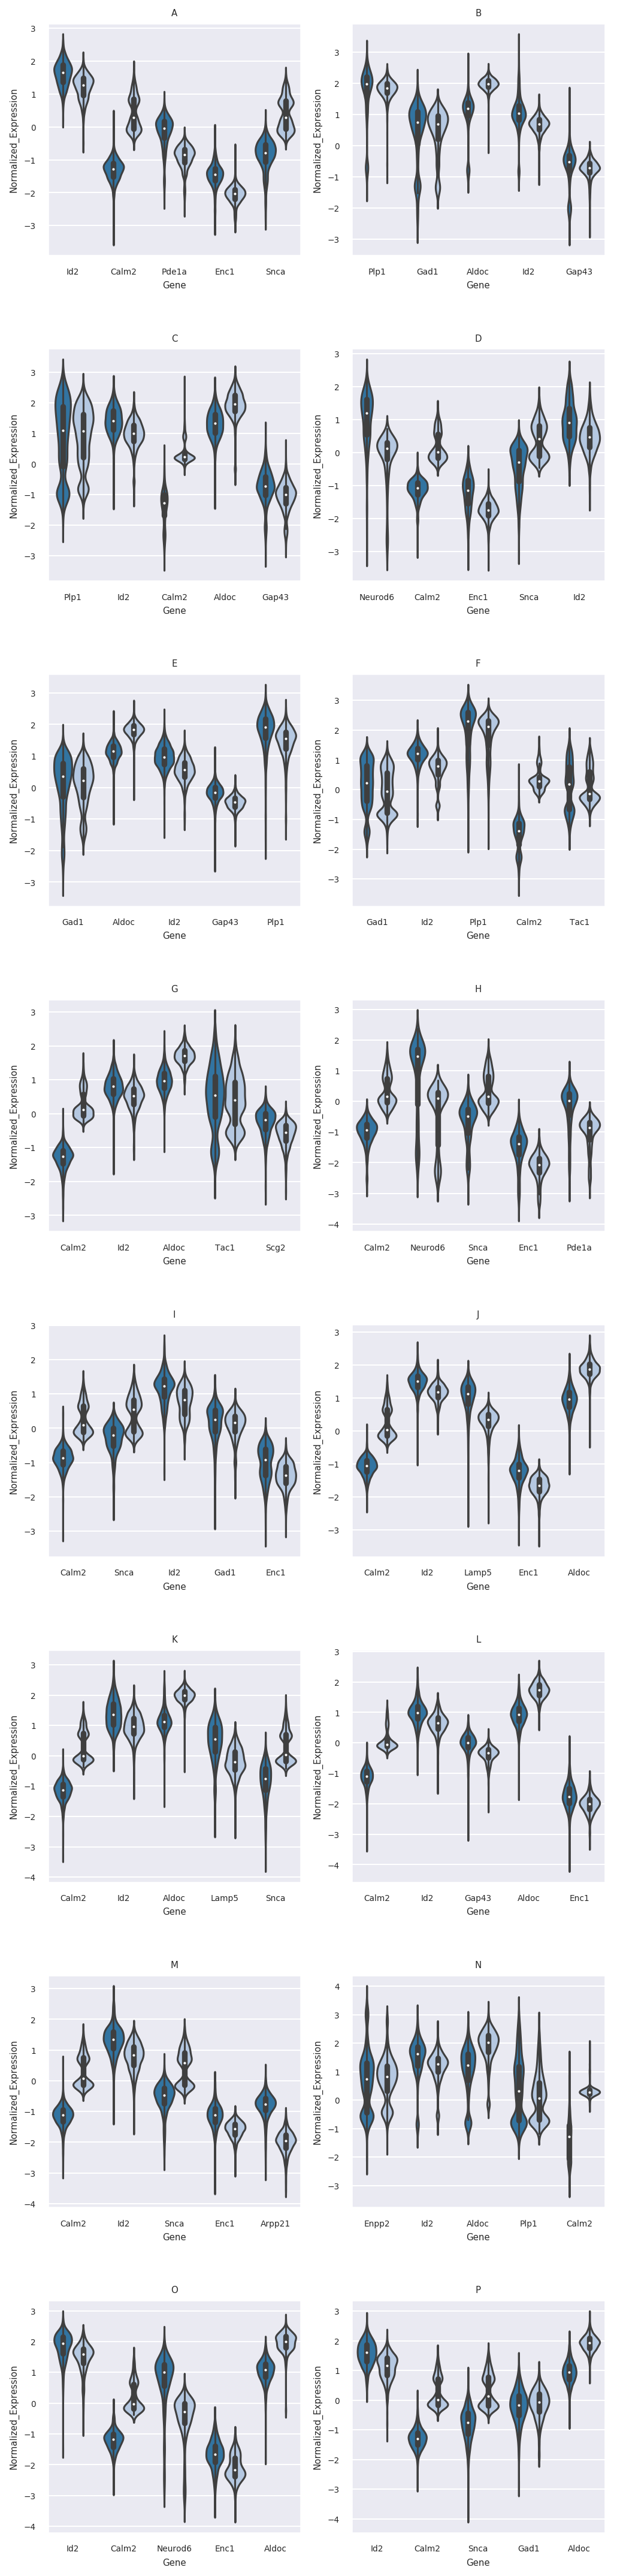

In [28]:
# Marker genes from single cell analysis
clusters = np.sort(markers.cluster.unique())

plt.figure(figsize=(8,128))
for i,c in enumerate(clusters):
    markers_tmp = markers[markers.cluster==c]
    markers_tmp = markers_tmp[markers_tmp.p_val_adj<0.01]
    marker_list = markers_tmp.avg_diff.abs().sort_values(ascending=False).head(5).index.values
    gene_exp = scaled_expr.loc[sample_df.top_cluster==i, marker_list].copy()
    gene_exp['s'] = sample_df.s
    gene_exp = gene_exp.melt('s')
    gene_exp = gene_exp.rename(columns={"variable": "Gene", "value": "Normalized_Expression"})

    plt.subplot(len(idx),2,i+1)
    ax = sns.violinplot(x="Gene", y="Normalized_Expression",hue='s' ,data=gene_exp)
    ax.legend_.remove()
    plt.title(c)
    plt.subplots_adjust(hspace=0.4)